In [250]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize

In [251]:
# Load data from pyuvsim simulation:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
data_sim = UVData()
data_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

In [252]:
# Inflate data
print(np.shape(data_sim.baseline_array))
data_sim.inflate_by_redundancy()
print(np.shape(data_sim.baseline_array))

(61,)
(666,)


In [253]:
# Remove autos
data_sim.select(ant_str='cross')
# Use only XX polarizations
data_sim.select(polarizations=[-5])

In [254]:
# Convert baselines to have u>0
data_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

In [255]:
baseline_groups, vec_bin_centers, lengths, conjugates = data_sim.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

In [258]:
# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(np.shape(baseline_groups)[0], 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(np.shape(baseline_groups)[0]):
    for bl_2 in [ind for ind in range(np.shape(baseline_groups)[0]) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176

In [259]:
# Check that the covariance matrix is full-rank
print(N_baseline_groups)
print(np.linalg.matrix_rank(baseline_cov_array))

60
60


In [315]:
# Grab model visibilities
model_visibilities = np.zeros(np.shape(baseline_groups)[0], dtype=np.complex_)
for red_group in range(np.shape(baseline_groups)[0]):
    # Use first visiblity in each redundant group
    model_visibilities[red_group] = data_sim.data_array[
        np.where(data_sim.baseline_array == baseline_groups[red_group][0])[0], 0, 0, 0
    ]

In [316]:
# Initialize the fitted visibilities to the model visibility values
visibilities_initialize = np.copy(model_visibilities)
# Initialize the gains to 1
gains_initialize = np.full(data_sim.Nants_data, 1.+0.j)
# Expand the initialized values
x0 = np.concatenate((
    np.real(gains_initialize), np.imag(gains_initialize),
    np.real(visibilities_initialize), np.imag(visibilities_initialize)
))

In [317]:
# Create the A matrix
a_mat = np.zeros((np.shape(data_visibilities)[0], np.shape(baseline_groups)[0]))
for red_group in range(np.shape(baseline_groups)[0]):
    for baseline in baseline_groups[red_group]:
        a_mat[np.where(data_sim.baseline_array == baseline)[0], red_group] = 1

In [318]:
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((np.shape(data_visibilities)[0], data_sim.Nants_data), dtype=np.complex_)
gains_exp_mat_2 = np.zeros((np.shape(data_visibilities)[0], data_sim.Nants_data), dtype=np.complex_)
for baseline in range(np.shape(data_visibilities)[0]):
    gains_exp_mat_1[baseline, data_sim.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim.ant_2_array[baseline]] = 1

In [367]:
def cost_function(
    x, 
    N_red_baselines, Nants, baseline_cov_array, model_visibilities, a_mat,
    gains_exp_mat, data_visibilities, model_variance
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:Nants]+1j*x[Nants:2*Nants]
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_array), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob+prior/model_variance

In [377]:
def add_visibility_noise(visibilities, stddev):
    noise_real = np.random.normal(0, stddev, np.shape(visibilities))
    noise_imag = np.random.normal(0, stddev, np.shape(visibilities))
    noisy_visibilities = np.copy(visibilities)
    noisy_visibilities += noise_real + 1j*noise_imag
    return noisy_visibilities

In [394]:
n_trials=3
noise_level = 2.
model_variance = 1
gain_vals_covariance = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
gain_vals_no_covariance = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)

for trial in range(n_trials):
    # Create data visibilities
    data_visibilities = add_visibility_noise(data_sim.data_array[:,0,0,0], 0.01)
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_array, 
            model_visibilities, a_mat, gains_exp_mat, data_visibilities, model_variance
        ),
        method='Nelder-Mead', options={'maxiter':100000}
    )
    print(result.message)
    gains_fit = result.x[:Nants]+1j*result.x[Nants:2*Nants]
    gain_vals_covariance[:, trial] = gains_fit

    result_no_cov = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, np.diag(np.full(np.shape(baseline_groups)[0], 1.)), 
            model_visibilities, a_mat, gains_exp_mat, data_visibilities, model_variance
        ),
        method='Nelder-Mead', options={'maxiter':100000}
    )
    print(result_no_cov.message)
    gains_fit_no_cov = result_no_cov.x[:Nants]+1j*result_no_cov.x[Nants:2*Nants]
    gain_vals_no_covariance[:, trial] = gains_fit_no_cov

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


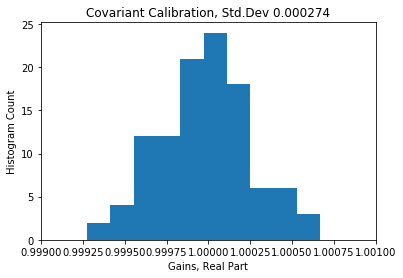

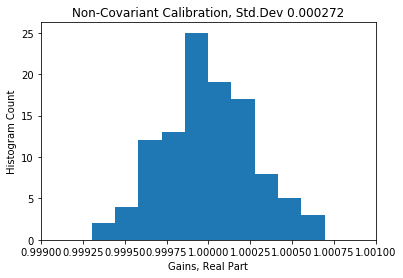

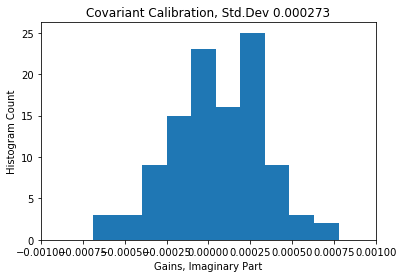

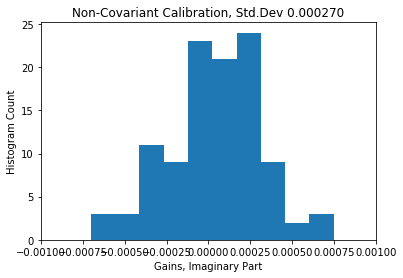

In [395]:
plot_range = .001

plt.hist(np.real(gain_vals_covariance).flatten())
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals_covariance))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.real(gain_vals_no_covariance).flatten())
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.real(gain_vals_no_covariance))))
plt.xlim(1-plot_range,1+plot_range)
plt.show()

plt.hist(np.imag(gain_vals_covariance).flatten())
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals_covariance))))
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(gain_vals_no_covariance).flatten())
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.title('Non-Covariant Calibration, Std.Dev {:f}'.format(np.std(np.imag(gain_vals_no_covariance))))
plt.xlim(-1*plot_range, plot_range)
plt.show()